In [19]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))
sampleSubmission <- read.csv(file.path("..", "data", "sampleSubmission.csv"))

In [22]:
#delets dependent variables
train.dub <- train.data[!duplicated(as.list(train.data))]

#Separate the dataset in predictors and responses
V.data.x = data.frame(train.dub[, -which(names(train.data) == "VALENCE.PLEASANTNESS")])   #All the features
V.data.y = train.data$VALENCE.PLEASANTNESS  #the response

In [23]:
library(tidymodels)
library(leaps)

#V.data = dataset with removed low variance features
length <- length(train.dub[1,])
V.data.x$Intensity = as.numeric(V.data.x$Intensity)
idx.low.var <- apply(V.data.x, 2, var) < 0.24 # identify pixels with low variance 
V.data <- data.frame(V.data.x)
V.data <- data.frame(V.data[,!idx.low.var])
V.data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS


In [29]:
#Correlation on the data : enlever tous les features qui ont une corrélation supérieure à 0.9
 
library(corrplot)
library(caret)
library(corrplot)
library(plyr)


corrData = scale(V.data, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
descrCor <- cor(corrData) # Access the correlation matrix (Pearson's coefficients)
#descrCor

highlyCorrelated <- findCorrelation(descrCor, cutoff=0.9)  #Renvoie les indices des features qui sont correlées à 0.9 ou au dessus
#highlyCorCol <- colnames(V.data)[highlyCorrelated]

UnCorrelatedData <- V.data[, -which(colnames(V.data) %in% highlyCorCol)]  #Data frame with only uncorrelated data
dim(UnCorrelatedData)

#Separate the dataset in predictors and responses
#UnCorrelatedData.x = data.frame(UnCorrelatedData[, -which(names(UnCorrelatedData) == "VALENCE.PLEASANTNESS")])   #All the features 
#UnCorrelatedData.y = UnCorrelatedData$VALENCE.PLEASANTNESS  #the response

[1] 708 364

In [30]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

In [14]:
#Forward selection with K-fold Cross Validation 
nvmax = 50
validation_data <- vfold_cv(UnCorrelatedData, v = 5)

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), nvmax = nvmax, method = 'forward')
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(fit, valid.set, id, formula))^2))
}
           
cv.errors <- sapply(validation_data$splits, fit_and_evaluate)
rowMeans(cv.errors)
          

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“41  linear dependencies found”Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“48  linear dependencies found”Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“39  linear dependencies found”Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“44  linear dependencies found”Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“40  linear dependencies found”

[1] 527.9875 523.0839 525.0003 516.4893 508.9329 519.0659 522.3858 529.5633
 [9] 528.6521 527.5043 524.3253 527.7683 529.1020 532.1581 537.8983 542.2333
[17] 540.7967 540.2171 544.2325 546.4501 551.0005 553.9059 548.3192 546.4149
[25] 546.3275 544.4649 541.1659 541.0741 535.0402 532.7261 535.0387 540.4709
[33] 544.9428 542.8837 546.0830 542.6363 544.3251 549.7694 551.6367 549.5943
[41] 553.0315 553.8047 548.5898 550.2068 548.2919 547.8414 547.6734 551.4379
[49] 552.5207 550.9630

In [44]:
#split the data set into a training set and a validation set
dim <- length(UnCorrelatedData[,1])
idx.validation <- sample(1:dim, dim/3)

train <- UnCorrelatedData[-idx.validation,]
validation <- UnCorrelatedData[idx.validation,]

validation.x = data.frame(validation[, -which(names(validation) == "VALENCE.PLEASANTNESS")])
validation.y = validation$VALENCE.PLEASANTNESS

train.x = data.frame(train[, -which(names(train) == "VALENCE.PLEASANTNESS")])
train.y = train$VALENCE.PLEASANTNESS

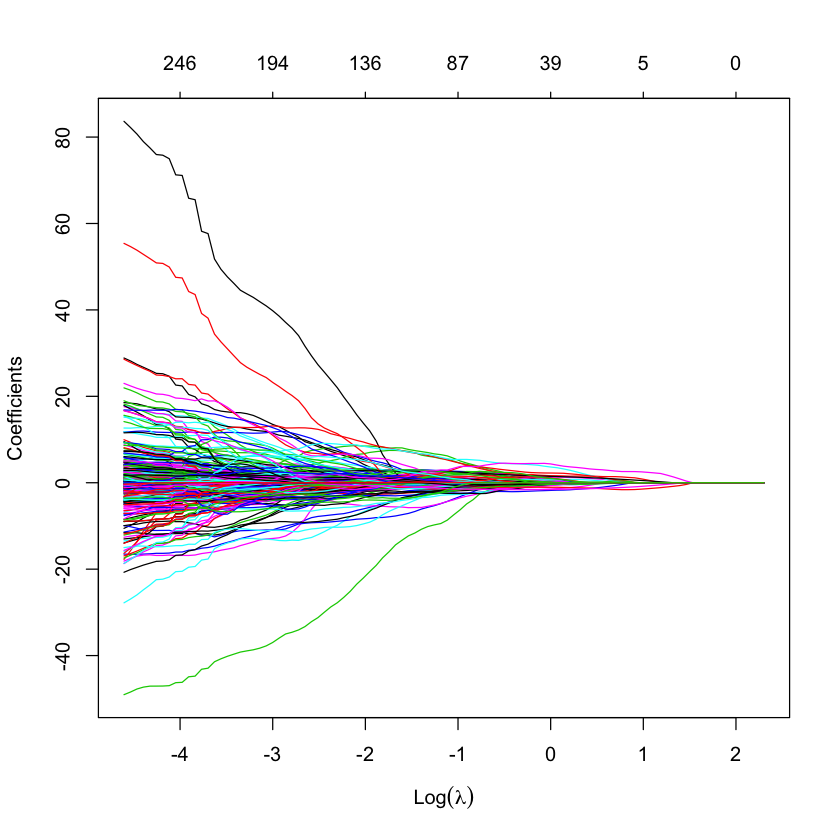

In [45]:
#Lasso regularization 
library(glmnet)
V.data.y = as.matrix(train.y)
V.data.x = as.matrix(train.x)
lasso.mod <- glmnet(V.data.x,V.data.y, alpha = 1, lambda = 10^seq(1, -2, length = 100))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

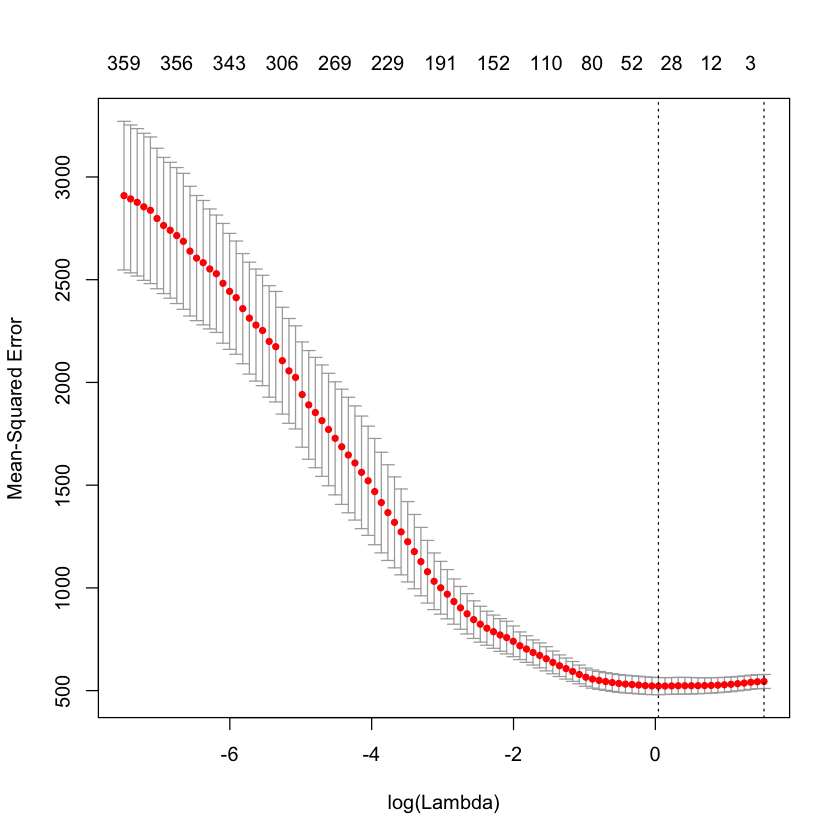

In [46]:
cv.lasso <- cv.glmnet(V.data.x, V.data.y, alpha = 1, nfold = 5)
plot(cv.lasso)

In [62]:
best.lasso <- glmnet(V.data.x, V.data.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = as.matrix(validation.x))

#MSE with Lasso linear model 
mean((pred - validation.y)^2)

[1] 470.5722

In [61]:
myCoefs = coef(best.lasso)
NonZeroCoeffs = myCoefs[which(myCoefs != 0 )]
CoeffNames = myCoefs@Dimnames[[1]][which(myCoefs != 0 ) ]
myResults <- data.frame(
  features = myCoefs@Dimnames[[1]][ which(myCoefs != 0 ) ], #intercept included
  coefs    = myCoefs              [ which(myCoefs != 0 ) ]  #intercept included
)
dim(myResults)
myResults

[1] 39  2

features,coefs
(Intercept),39.80089951
Intensity,0.44991917
D.Dtr05,-0.09936241
D.Dtr07,0.08698507
Chi_D.Dt,0.39802419
GATS5s,-0.08711165
P_VSA_LogP_5,0.09660502
P_VSA_LogP_6,-0.04742551
P_VSA_MR_7,-0.11049318
P_VSA_s_5,-0.20284055
